We train a `sklearn` `RandomForest` model, then create a Shparkley wrapper implementing the Shparkley API. 

This demonstrator shows that Shparkley works with any model that can implement the wrapper class and which can generate predictions given a dataset in local (to each executor) memory.


# Load Spark Kernel
Using `findspark`, but many other ways exist too. See ([Installing Spark](https://spark.apache.org/downloads.html))

In [398]:
import seaborn as sns
from tempfile import mktemp
from os import system

import findspark
findspark.init() #  Adds `pyspark` to `sys.path` at runtime
import networkx as nx
import pyspark
from pyspark.sql import Row, SQLContext
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.tree import export_graphviz


from IPython.display import display, Image
from sklearn.base import ClassifierMixin
from typing import Any, Dict, List, Set


from affirm.model_interpretation.shparkley.spark_shapley import (
    compute_shapley_for_sample,
    ShparkleyModel,
)

In [2]:
pyspark.__version__

'3.0.1'

In [3]:
! echo $JAVA_HOME

/Library/Java/JavaVirtualMachines/jdk-14.0.1.jdk/Contents/Home


In [4]:
! echo $SPARK_HOME

/usr/local/spark


Create connection to Spark cluster

In [5]:
sc = pyspark.SparkContext(appName="shparkley_example")

In [6]:
sql_context = SQLContext(sc)

## Verify it's started 

In [7]:
! jps -lvm | grep -i spark

86490 org.apache.spark.deploy.SparkSubmit pyspark-shell -Xmx1g


 `org.apache.spark.deploy.SparkSubmit pyspark-shell` is running -- looks good. 

[Look more at configuration:](https://spark.apache.org/docs/latest/cluster-overview.html)
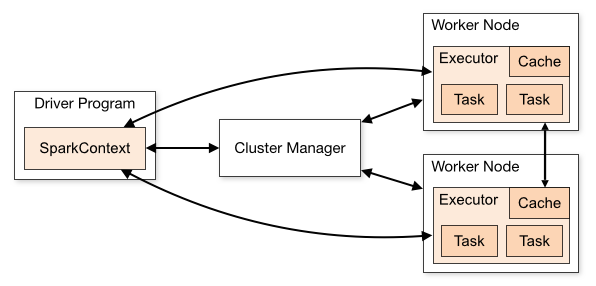

In [8]:
sc.getConf().getAll()

[('spark.app.name', 'shparkley_example'),
 ('spark.driver.host', '192.168.1.6'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.port', '53735'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.executor.id', 'driver'),
 ('spark.app.id', 'local-1603751496479'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [9]:
sc.defaultParallelism, sc.defaultMinPartitions

(8, 2)

This means that by default, `pyspark.DataFrame`s will be created with 8 partitions. 

This is because `sc.parallelize` [here (link)](https://github.com/apache/spark/blob/97605cd1269987ed5ba3013a5f8497375ce8913e/python/pyspark/sql/session.py#L452) is used to convert from local-memory `DataFrame` which uses its `defaultParallelism`. 

There is [no obvious way](https://stackoverflow.com/a/28793407/588437) to get the number of [**executors**](https://spark.apache.org/docs/latest/cluster-overview.html) from the `pyspark` API. 


# Generate Example Dataset
We generate an example loan repayment dataset based on the simplistic assumption that whether a user repays is defined according to a simple tree with three features. 

## Create Ground Truth Tree

In [165]:
from typing import Callable
from inspect import getsourcelines
from numbers import Number

In [168]:
class Criterion:
    """
    Stores a lambda function of the form lambda x: x <operator> c 
    """
    def __init__(self, cutoff: Number, comparison_operator: str):
        self.cutoff = cutoff
        self.comparison_operator = comparison_operator    
    
    def __str__(self):
        """
        Just show the criterion, assuming a lambda function
        """
        return (f'{self.comparison_operator} {self.cutoff}')

    def __repr__(self):
        return self.__str__()

In [537]:
str(Criterion(comparison_operator='<=', cutoff=700))

'<= 700'

In [568]:
graph = nx.DiGraph()
graph.add_edge(
    "fico", "loan_amount", criterion=Criterion(comparison_operator="<=", cutoff=700)
)
graph.add_edge(
    "fico", "leaf_1", criterion=Criterion(comparison_operator=">", cutoff=700)
)
graph.add_edge(
    "loan_amount", "leaf_2", criterion=Criterion(comparison_operator="<=", cutoff=1000)
)
graph.add_edge(
    "loan_amount",
    "number_of_delinquencies",
    criterion=Criterion(comparison_operator=">", cutoff=1000),
)
graph.add_edge(
    "number_of_delinquencies",
    "leaf_3",
    criterion=Criterion(comparison_operator="<=", cutoff=0),
)
graph.add_edge(
    "number_of_delinquencies",
    "leaf_4",
    criterion=Criterion(comparison_operator=">", cutoff=0),
)


graph.nodes["leaf_1"]["p_delinquency"] = 0.01
graph.nodes["leaf_2"]["p_delinquency"] = 0.05
graph.nodes["leaf_3"]["p_delinquency"] = 0.03
graph.nodes["leaf_4"]["p_delinquency"] = 0.20

In [569]:
from networkx.drawing.nx_pydot import graphviz_layout
import matplotlib.pyplot as plt

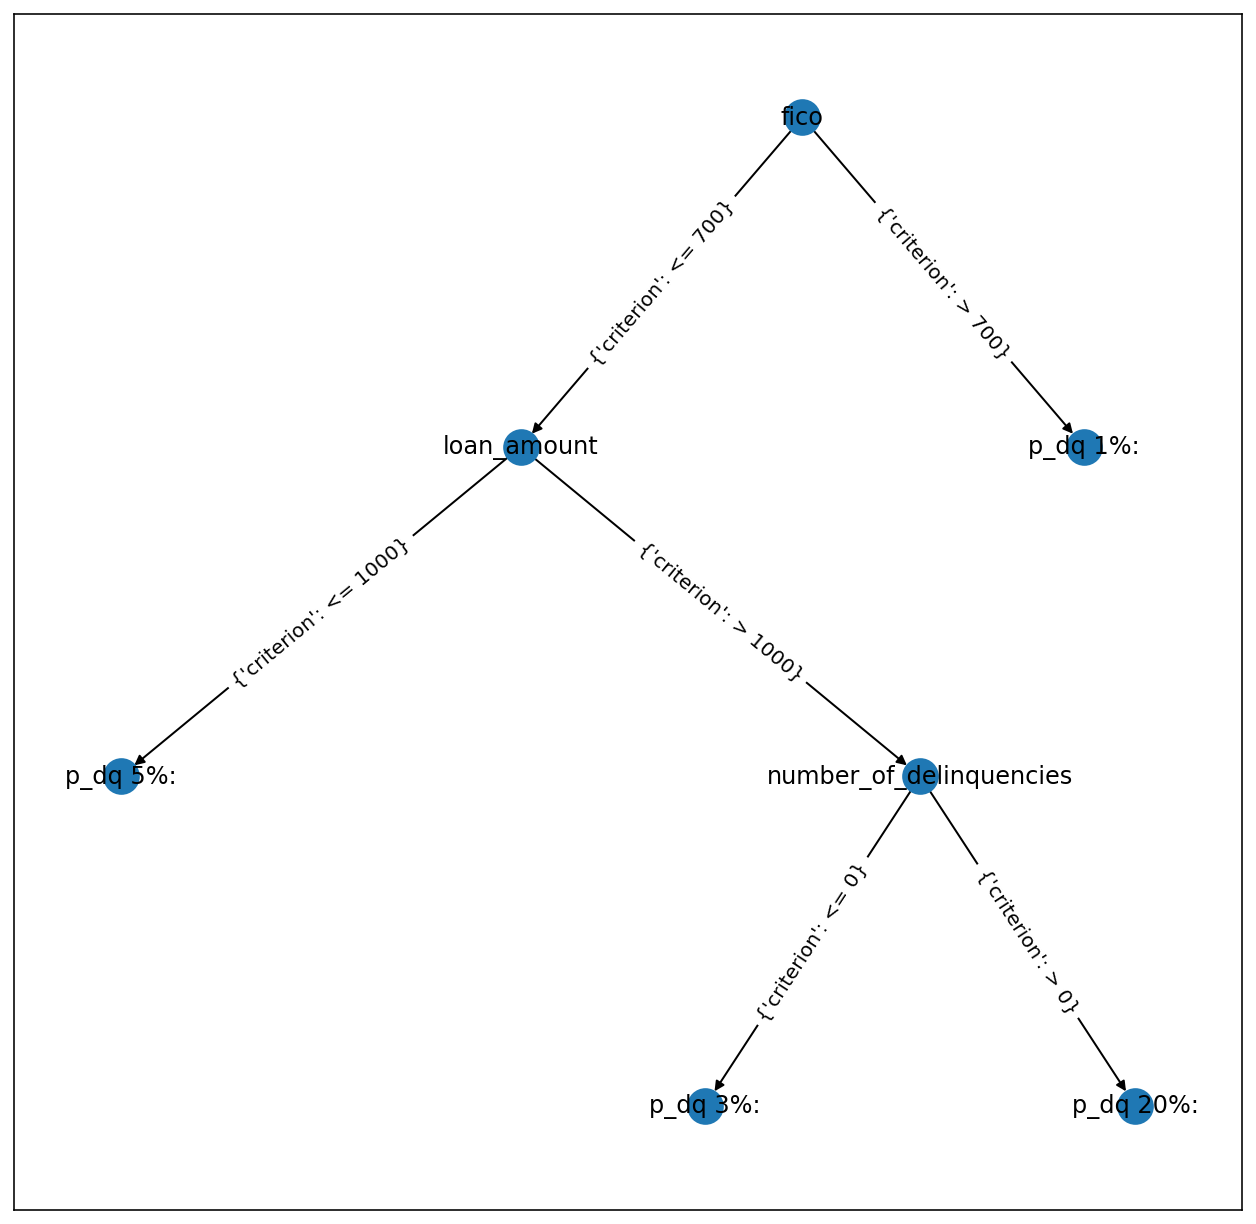

In [570]:
plt.figure(figsize=(11, 11))
labels = {
    k: "p_dq {0:.0f}%:".format(v.get("p_delinquency") * 100) if v else k
    for (k, v) in dict(graph.nodes).items()
}

positions = graphviz_layout(graph, prog="dot")
nx.draw_networkx(graph, positions, labels=labels)
_ = nx.draw_networkx_edge_labels(graph, positions)

## Generate from Tree
For each leaf node, generate data columns fitting the criteria and 1000 rows (Bernoulli with $p = $ `p_dq`)

In [571]:
from typing import List, Dict

In [572]:
def criteria_dict_to_row_values(
    criteria: Dict[str, Criterion], default_row_values: Dict[str, Number]
) -> Dict[str, Number]:
    """
    Given a dictionary with column_name -> Criteria mappinig, output what to set the feature row values to. 
    """
    output_row_values = default_row_values.copy()
    for column_name, criterion in criteria.items():
        if criterion.comparison_operator == "<=":
            output_row_values.update(
                {column_name: criterion.cutoff}
            )  # set feature value to exactly the cutoff if <=
        elif criterion.comparison_operator == ">":
            output_row_values.update(
                {column_name: criterion.cutoff + 1}
            )  # set feature value to cutoff + 1  if >
        else:
            raise ValueError(f"Unsupported {criterion.comparison_operator=}")

    return output_row_values

In [573]:
def tree_to_leaf_row_values(
    tree: nx.DiGraph, row_value_fn: Callable, default_row_values: Dict[str, Number]
) -> Dict[str, Dict[str, Number]]:
    """
    Return, for list of leaf nodes, a dictionary mapping column name to value to generate. Note: not impleneted for recurring instances of the same feature along a single path to a leaf. 
    """
    leaf_row_values = {}
    # Get root name
    root_name = [n for (n, d) in tree.in_degree() if d == 0][0]
    # Get criteria for each leaf
    for node in tree:
        if tree.out_degree(node) == 0:  # leaf node
            criteria = {}
            for path in next(
                nx.all_simple_edge_paths(tree, root, node)
            ):  # only one path, so calling next() once gets it (math.stackexchange.com/a/1523566/440173)
                criteria[path[0]] = tree.edges[path]["criterion"]

            # Translate criteria to row value dict
            leaf_row_values[node] = row_value_fn(criteria, default_row_values)
            
    return leaf_row_values

In [574]:
DEFAULT_ROW_VALUES = {
    'fico': 350,
    'loan_amount': 1,
    'number_of_delinquencies': 0,
    'repaid_all_previous_affirm_loans': 0,
}

In [575]:
row_values_per_leaf = tree_to_leaf_row_values(
    tree=graph,
    row_value_fn=criteria_dict_to_row_values,
    default_row_values=DEFAULT_ROW_VALUES,
)

In [576]:
row_values_per_leaf

{'leaf_1': {'fico': 701,
  'loan_amount': 1,
  'number_of_delinquencies': 0,
  'repaid_all_previous_affirm_loans': 0},
 'leaf_2': {'fico': 700,
  'loan_amount': 1000,
  'number_of_delinquencies': 0,
  'repaid_all_previous_affirm_loans': 0},
 'leaf_3': {'fico': 700,
  'loan_amount': 1001,
  'number_of_delinquencies': 0,
  'repaid_all_previous_affirm_loans': 0},
 'leaf_4': {'fico': 700,
  'loan_amount': 1001,
  'number_of_delinquencies': 1,
  'repaid_all_previous_affirm_loans': 0}}

In [577]:
import pandas as pd

In [578]:
from scipy.stats import bernoulli

In [579]:
def generate_rows_per_leaf(
    tree: nx.DiGraph, row_values_per_leaf: Dict[str, Dict[str, Number]], n_per_leaf=100
) -> pd.DataFrame:
    dfs = []
    for leaf_name, leaf_row_values in row_values_per_leaf.items():
        leaf_df = pd.DataFrame(
            columns=list(leaf_row_values.keys()) + ["deliquent_label"],
            index=range(n_per_leaf),
        )
        leaf_df.loc[range(n_per_leaf), leaf_row_values.keys()] = list(
            leaf_row_values.values()
        )

        # Sample based on p_deliquency
        leaf_df.loc[range(n_per_leaf), "deliquent_label"] = bernoulli.rvs(
            p=tree.nodes[leaf_name]["p_delinquency"], size=n_per_leaf, random_state=42
        )
        dfs.append(leaf_df)

    return pd.concat(dfs, ignore_index=True)

In [580]:
generated_loans_with_labels = generate_rows_per_leaf(graph, row_values_per_leaf, n_per_leaf=1000)

In [581]:
generated_loans_with_labels[list(DEFAULT_ROW_VALUES.keys())] = generated_loans_with_labels[list(DEFAULT_ROW_VALUES.keys())].apply(pd.to_numeric)

generated_loans_with_labels.loc[:, 'deliquent_label'] = generated_loans_with_labels['deliquent_label'].astype(bool)

In [582]:
generated_loans_with_labels.sample(10, random_state=47)

,fico,loan_amount,number_of_delinquencies,repaid_all_previous_affirm_loans,deliquent_label
1568,700,1000,0,0,False
648,701,1,0,0,False
3616,700,1001,1,0,False
3695,700,1001,1,0,False
2207,700,1001,0,0,False
2759,700,1001,0,0,False
612,701,1,0,0,False
2596,700,1001,0,0,False
534,701,1,0,0,False
532,701,1,0,0,True


In [583]:
generated_loans_with_labels['deliquent_label'].value_counts()

False    3727
True      273
Name: deliquent_label, dtype: int64

In [584]:
generated_loans_with_labels.describe()

,fico,loan_amount,number_of_delinquencies,repaid_all_previous_affirm_loans
count,4000.0000,4000.0000,4000.0000,4000.0
mean,700.2500,750.7500,0.2500,0.0
std,0.4331,432.9227,0.4331,0.0
min,700.0000,1.0000,0.0000,0.0
25%,700.0000,750.2500,0.0000,0.0
50%,700.0000,1000.5000,0.0000,0.0
75%,700.2500,1001.0000,0.2500,0.0
max,701.0000,1001.0000,1.0000,0.0


In [585]:
generated_loans_with_labels.shape

(4000, 5)

# Fit Sample Model

In [586]:
N_ESTIMATORS = 3

In [587]:
import numpy as np

## Add high weights to handle unbalanced DQ

In [588]:
generated_loans_with_labels.loc[:, "weight"] = np.where(
    generated_loans_with_labels["deliquent_label"] == True, 10.0, 1.0
)

In [589]:
np.random.seed(42)
train, test = train_test_split(generated_loans_with_labels)

In [590]:
train.shape, test.shape

((3000, 6), (1000, 6))

In [591]:
random_forest_classifier = RandomForestClassifier(n_estimators=N_ESTIMATORS)

In [592]:
fitted_model = random_forest_classifier.fit(
    X=train.drop(["deliquent_label", "weight"], axis=1),
    y=train["deliquent_label"],
    sample_weight=train["weight"],
)

## Sanity-Check Fit

In [593]:
from sklearn.metrics import plot_confusion_matrix

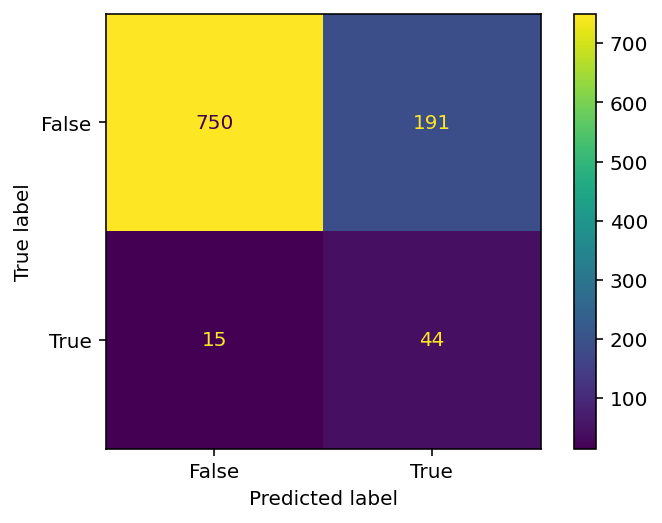

In [594]:
_ = plot_confusion_matrix(
    estimator=fitted_model,
    X=test.drop(["deliquent_label", "weight"], axis=1),
    y_true=test["deliquent_label"],
)

In [597]:
print(
    "Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}".format(
        precision_score(
            y_true=test["deliquent_label"],
            y_pred=fitted_model.predict(test.drop(["deliquent_label", "weight"], axis=1)),
        ),
        recall_score(
            y_true=test["deliquent_label"],
            y_pred=fitted_model.predict(test.drop(["deliquent_label", "weight"], axis=1)),
        ),
        f1_score(
            y_true=test["deliquent_label"],
            y_pred=fitted_model.predict(test.drop(["deliquent_label", "weight"], axis=1)),
        ),
    )
)

Precision = 0.19, Recall = 0.75, F1 = 0.30


When taking into account sample weights, confusion matrix looks much more reasonable. 

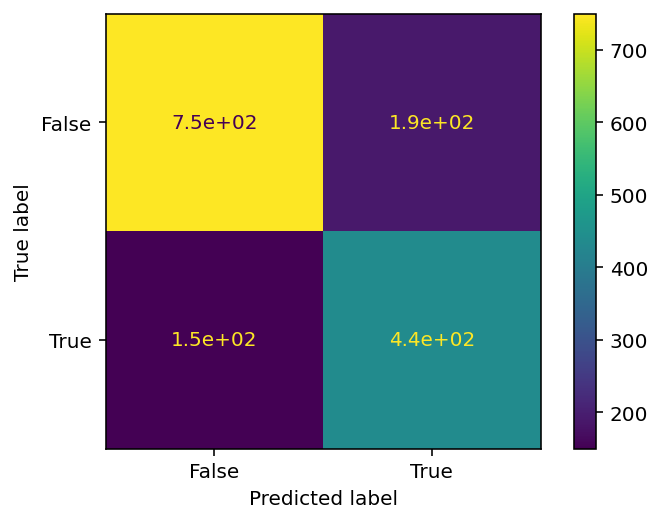

In [596]:
_ = plot_confusion_matrix(
    estimator=fitted_model,
    X=test.drop(["deliquent_label", "weight"], axis=1),
    y_true=test["deliquent_label"],
    sample_weight=test['weight'],
)

In [598]:
print(
    "Precision = {:.2f}, Recall = {:.2f}, F1 = {:.2f}".format(
        precision_score(
            y_true=test["deliquent_label"],
            y_pred=fitted_model.predict(test.drop(["deliquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
        recall_score(
            y_true=test["deliquent_label"],
            y_pred=fitted_model.predict(test.drop(["deliquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
        f1_score(
            y_true=test["deliquent_label"],
            y_pred=fitted_model.predict(test.drop(["deliquent_label", "weight"], axis=1)),
            sample_weight=test['weight'],
        ),
    )
)

Precision = 0.70, Recall = 0.75, F1 = 0.72


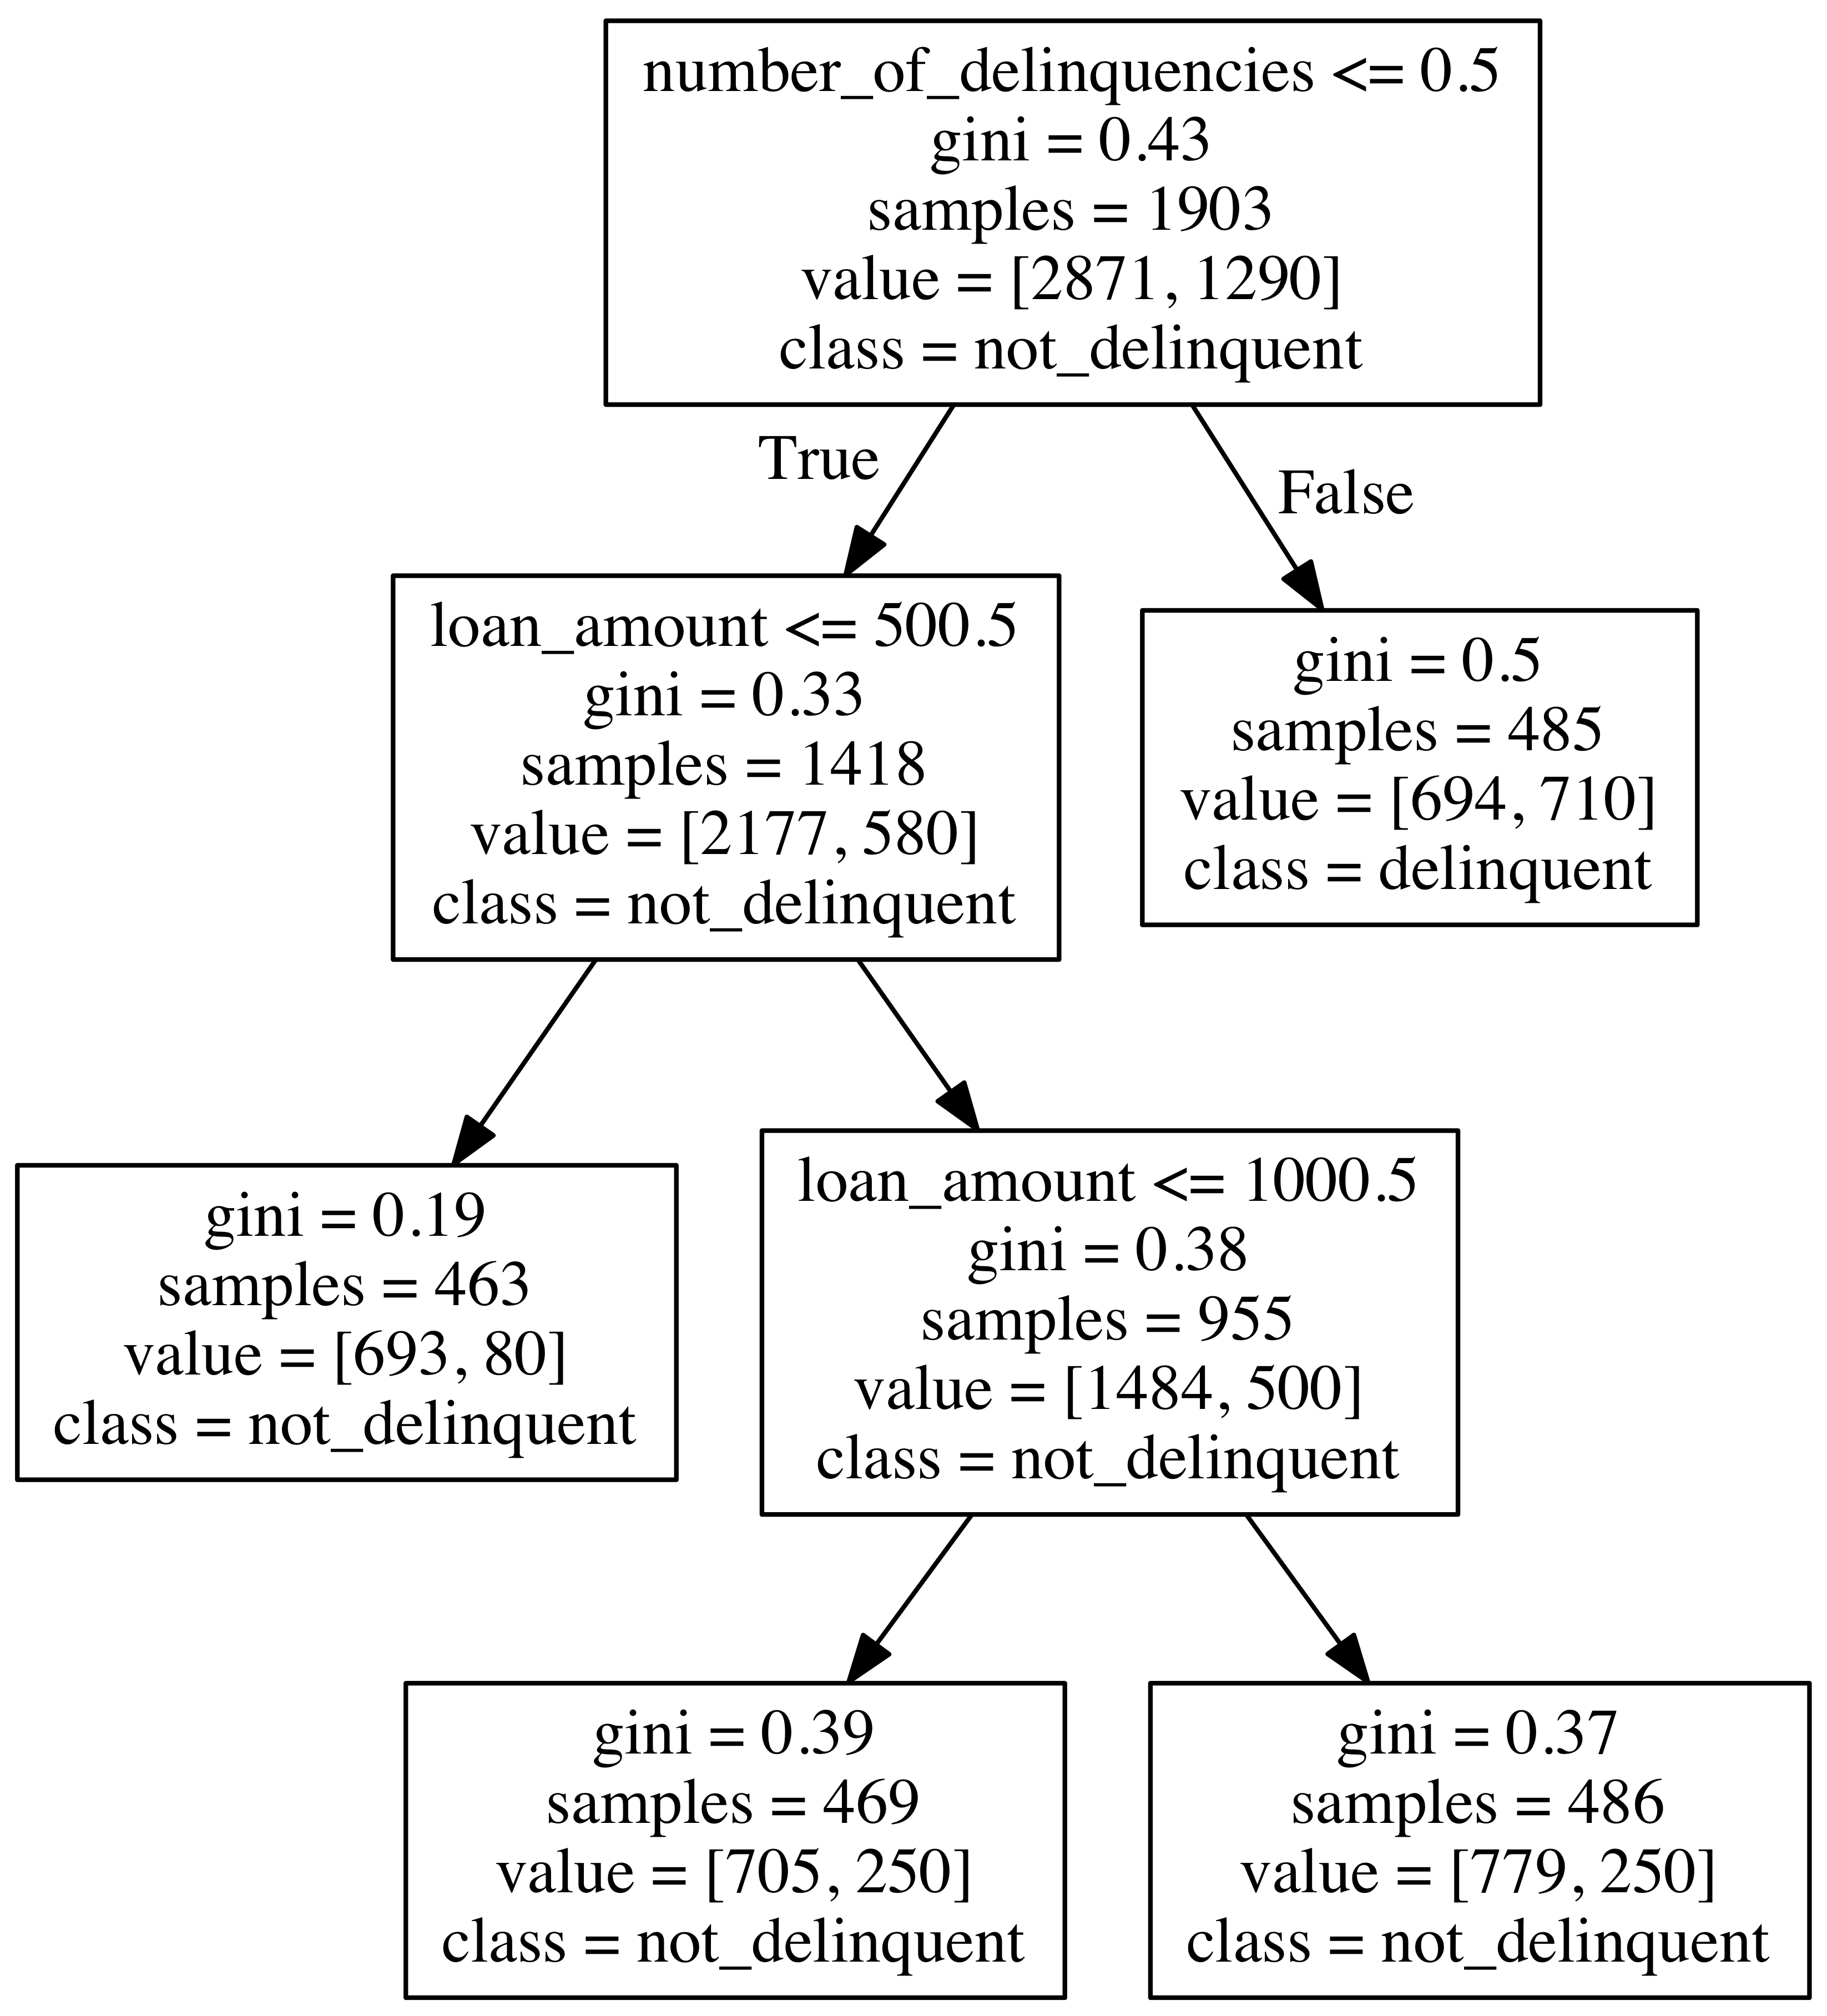

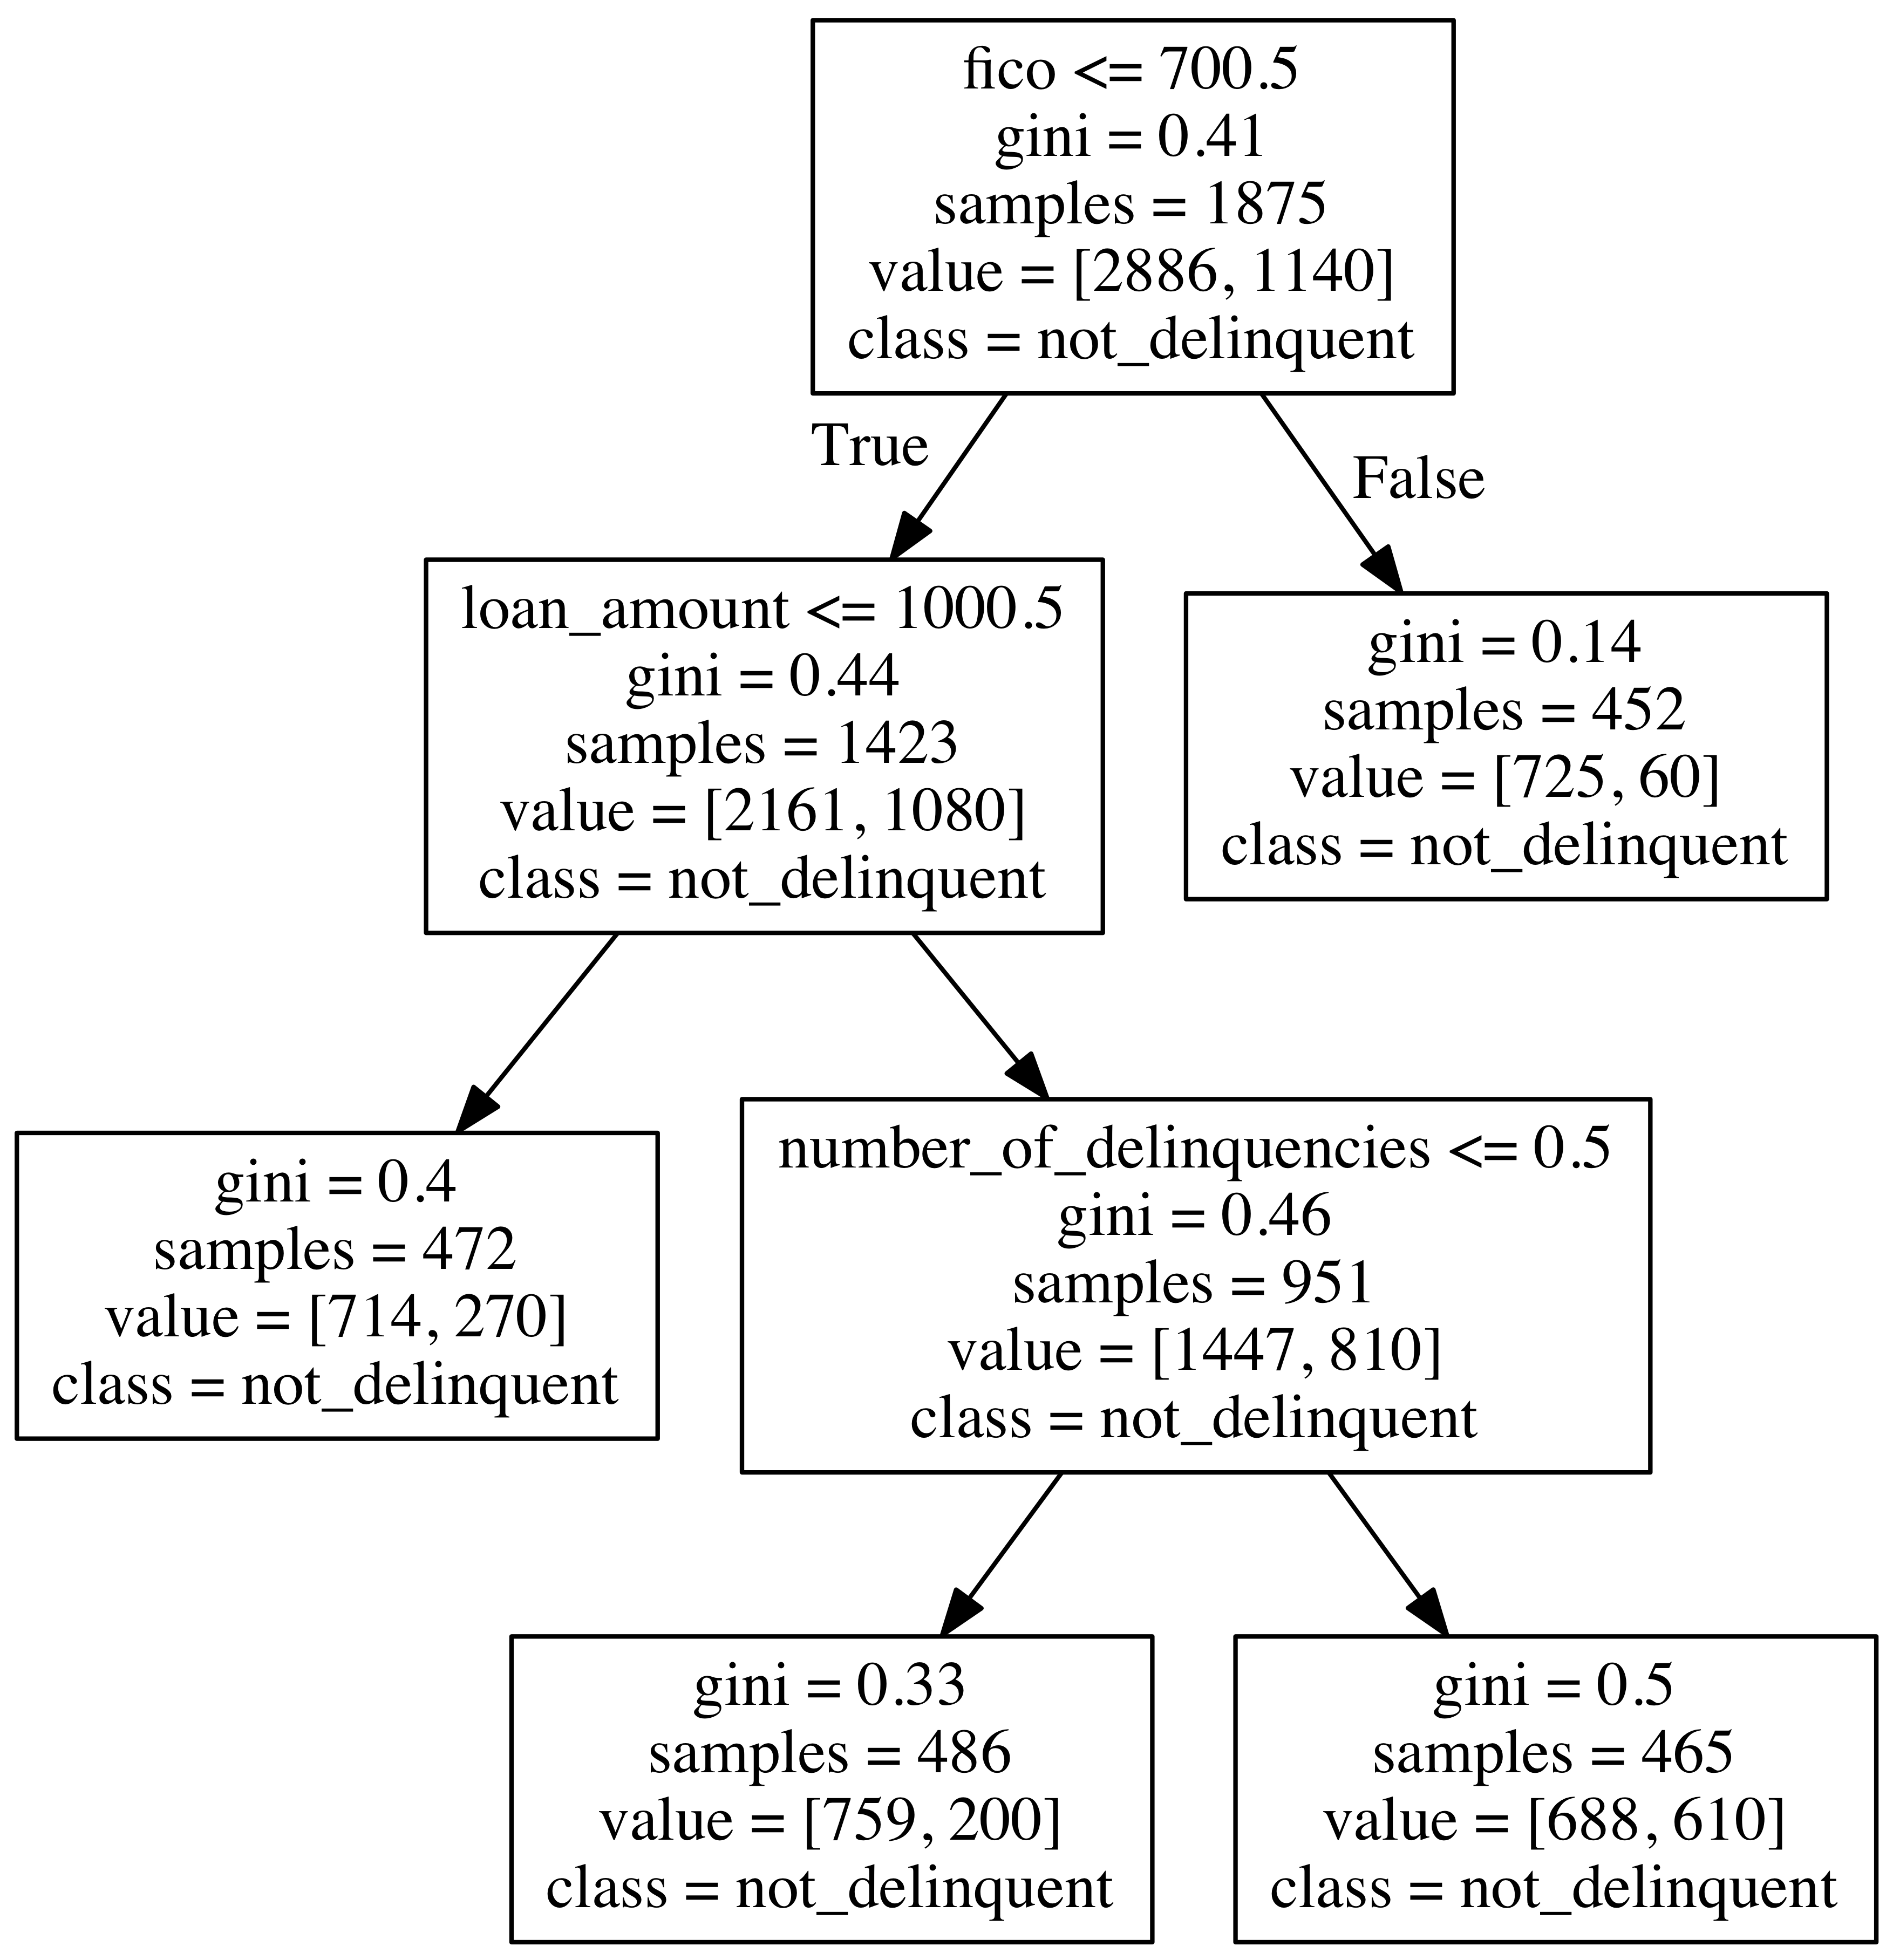

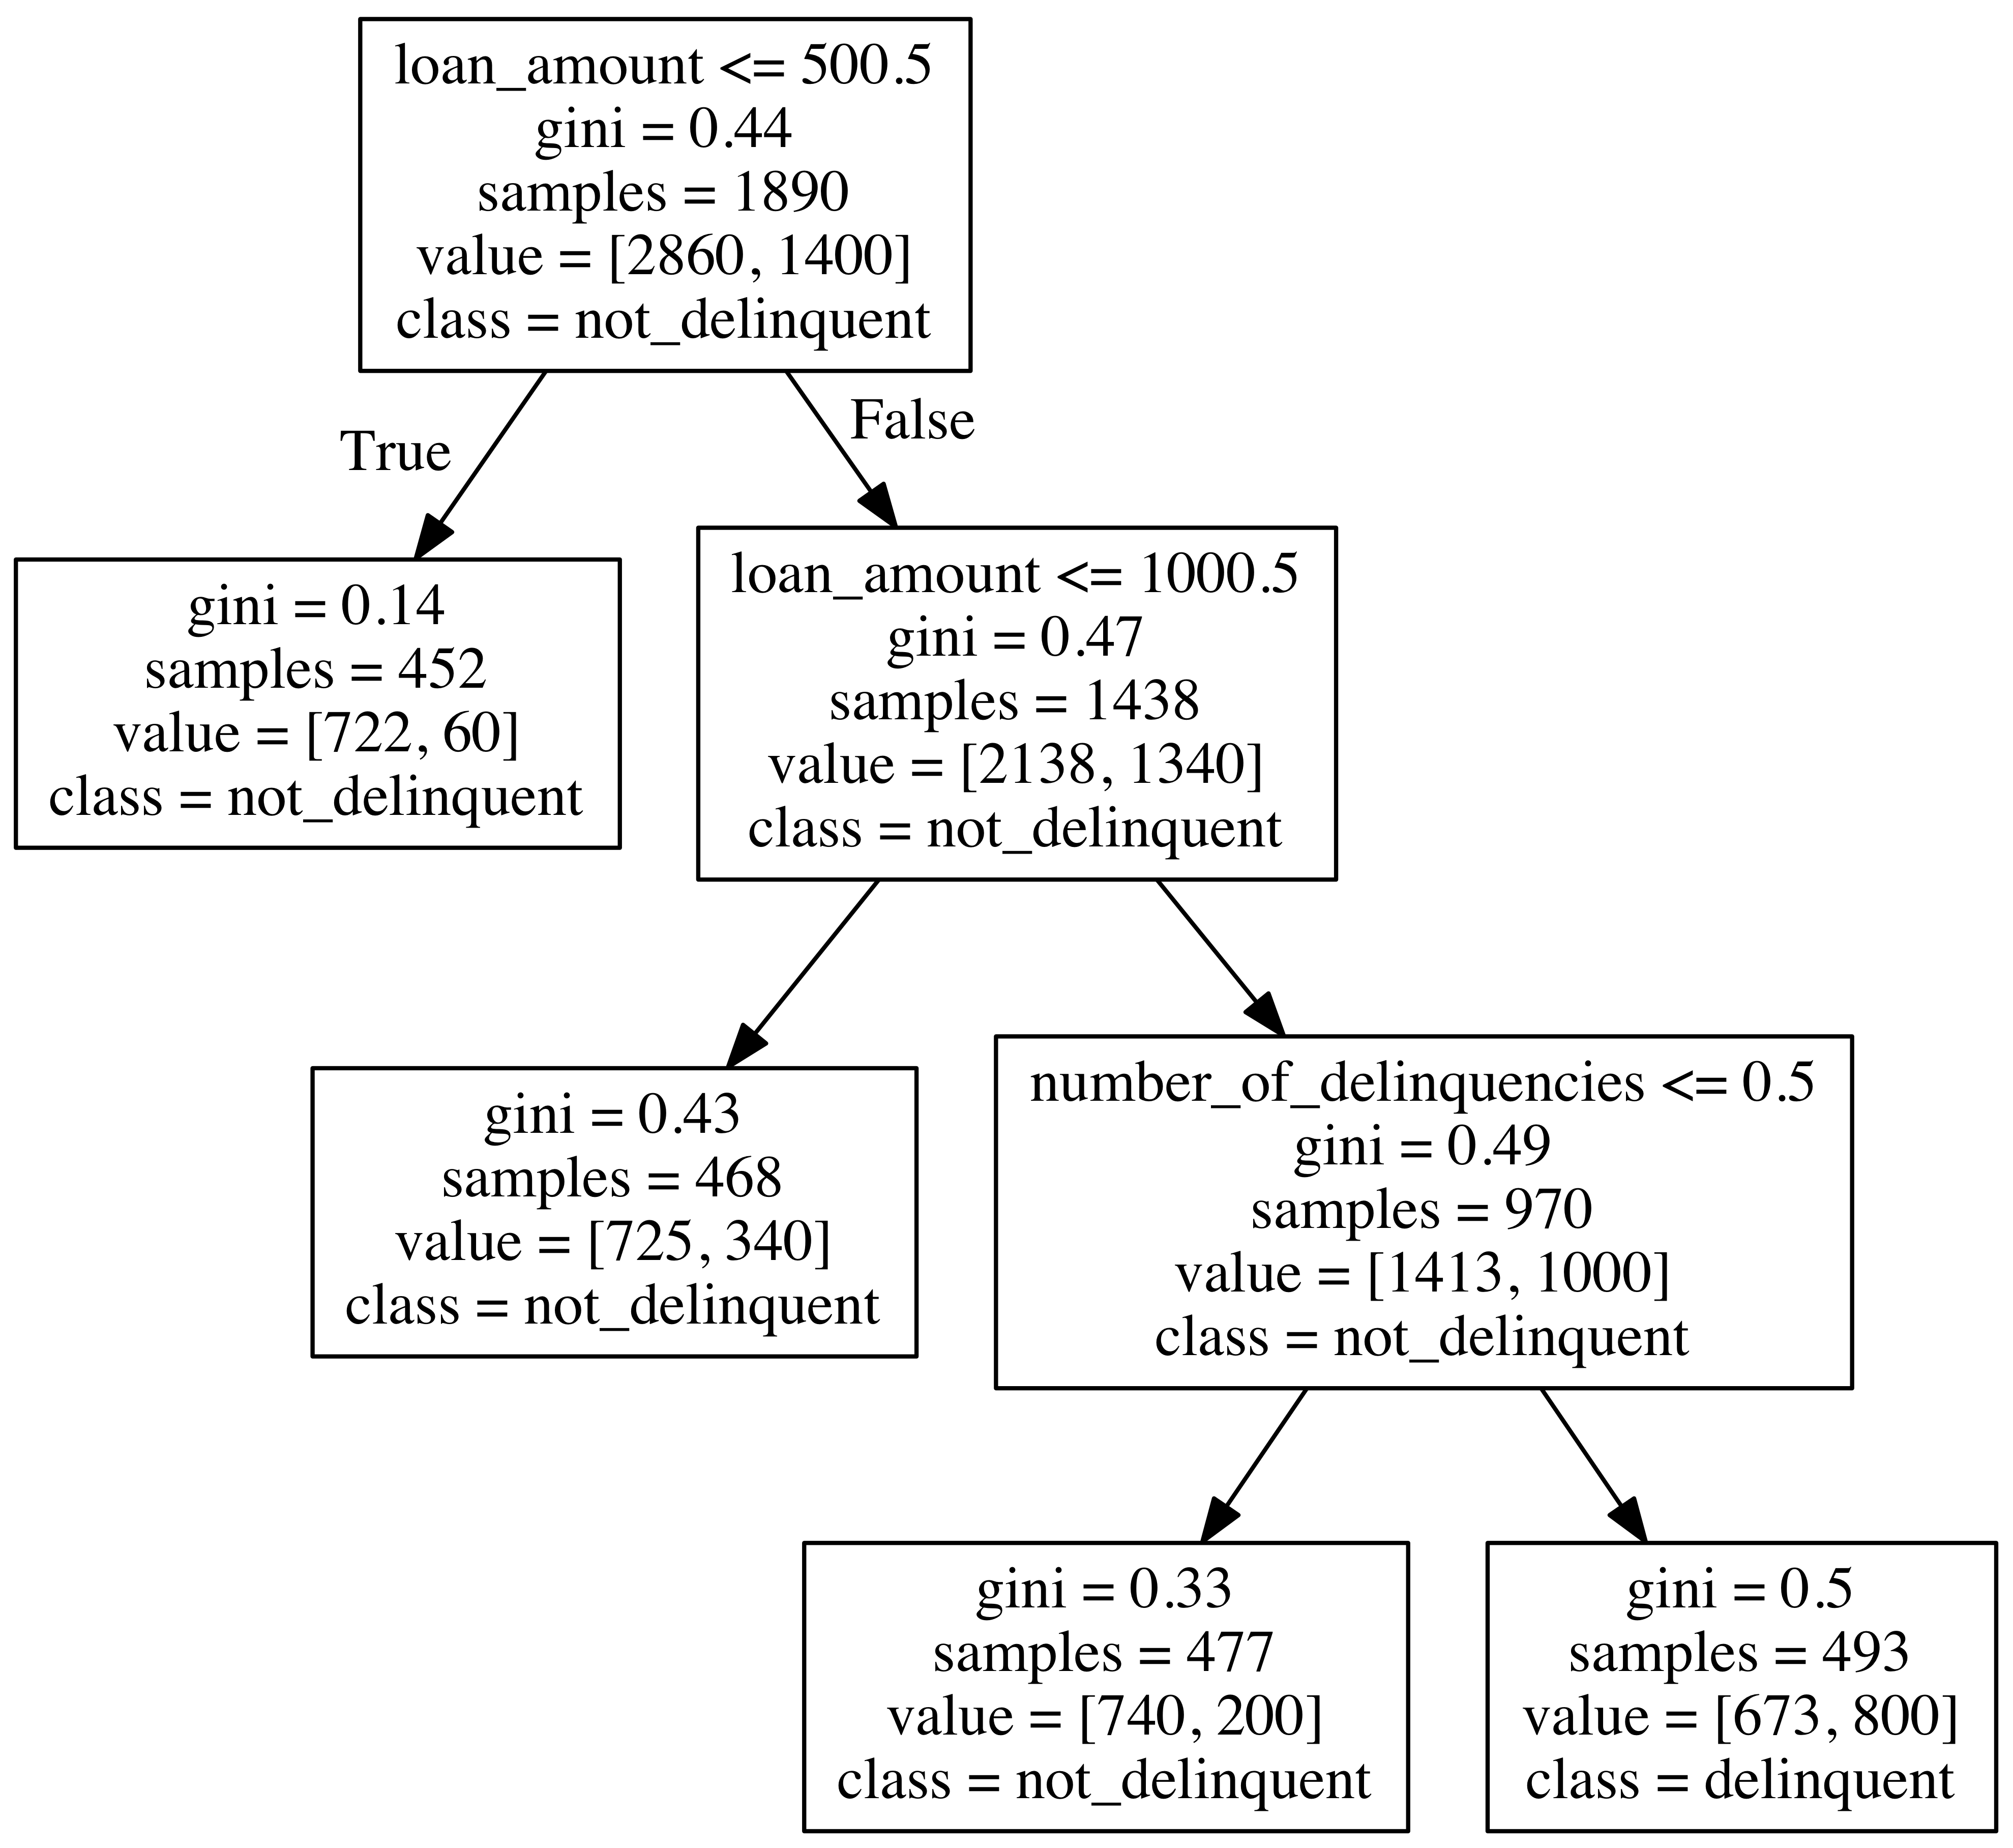

In [567]:
images = []
for estimator in fitted_model.estimators_:
    dot_file = mktemp(suffix='.dot')
    png_file = mktemp(suffix='.png')
    export_graphviz(estimator, out_file=dot_file, feature_names = generated_loans_with_labels.columns[:4], class_names=['not_delinquent', 'delinquent'], precision=2)
    system(f'dot -Tpng {dot_file} -o {png_file} -Gdpi=600')
    images.append(Image(png_file, width=300))

display(*images)

# Explain with Shapley

Create wrapper class. Note that within `predict`, we _cannot_ create a new distributed in-memory dataset, as this needs to be executed locally to the executor. This is a minor restriction as most models have relatively-fast inferencing, and also opens us up to use spark to accelerate the Shapley algorithm on a wide variety of existing models rather than `pyspark.mllib` and `pyspark.ml` models. If needed, spark models can be converted using [ONNX](https://github.com/onnx/onnxmltools) or similar to a model which can predict on a local executor. 

In [511]:
class MyShparkleyModel(ShparkleyModel):
    def __init__(self, model: ClassifierMixin, required_features: Set[str]):
        self._model = model
        self._required_features = set(required_features)

    def predict(self, feature_matrix: List[Dict[str, Any]]) -> List[float]:
        pd_df = pd.DataFrame.from_dict(feature_matrix)
        preds = self._model.predict(pd_df)
        return preds

    def get_required_features(self) -> Set[str]:
        return self._required_features

In [512]:
model_with_shparkley_interface = MyShparkleyModel(
    model=fitted_model, required_features=generated_loans_with_labels.columns[:4]
)

## Sanity Check of Wrapper API

In [513]:
model_with_shparkley_interface.get_required_features()

{'fico',
 'loan_amount',
 'number_of_delinquencies',
 'repaid_all_previous_affirm_loans'}

In [514]:
test.iloc[0:1, 0:4].to_dict()

{'fico': {555: 701},
 'loan_amount': {555: 1},
 'number_of_delinquencies': {555: 0},
 'repaid_all_previous_affirm_loans': {555: 0}}

In [515]:
model_with_shparkley_interface.predict(test.iloc[0:1, 0:4].to_dict())

array([False])

## Explain Some Test Datapoints

### Load Training DataFrame into Spark

In [29]:
sql_context = SQLContext(sc)

In [30]:
train_spark_df = sql_context.createDataFrame(train)

In [36]:
train_spark_df.rdd.getNumPartitions()

8

As foreshadowed by earlier `defaultParallelism`

In [31]:
train_spark_df.describe().show()

+-------+------------------+-------------------+------------------+------------------+------------------+
|summary|      sepal_length|        sepal_width|      petal_length|       petal_width|           species|
+-------+------------------+-------------------+------------------+------------------+------------------+
|  count|                75|                 75|                75|                75|                75|
|   mean|5.8293333333333335|  3.198666666666667| 3.613333333333334|1.1920000000000002|              0.52|
| stddev|0.9721491006393382|0.41508492564232624|2.1224242471015744|0.9384806582694958|0.5029641865709455|
|    min|               4.3|                2.3|               1.1|               0.1|               0.0|
|    max|               7.9|                4.4|               6.9|               2.5|               1.0|
+-------+------------------+-------------------+------------------+------------------+------------------+



### Explain the First Test Datapoint

In [78]:
query_row = Row(**test.iloc[4,:].to_dict())
query_row

Row(sepal_length=5.1, sepal_width=3.8, petal_length=1.9, petal_width=0.4, species=0.0)

In [73]:
fitted_model.predict(test.iloc[2:3, :].drop("species", axis=1))

array([1.])

In [74]:
REV_TARGET_ENCODING

{0.0: 'setosa', 1.0: 'virginica'}

In [79]:
compute_shapley_for_sample(
    df=train_spark_df,
    model=model_with_shparkley_interface,
    row_to_investigate=query_row,
)

{'petal_width': 0.0,
 'sepal_width': 0.0,
 'petal_length': 0.0,
 'sepal_length': 0.0}